In [12]:
import numpy as np

def angle(v1, v2):
    cos_x = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(max(-1, min(1, cos_x)))

def centroid(points):
    n = len(points)
    return np.sum(points, axis=0) / n

def fit_plane(points):
    ccm = np.zeros((3, 3))
    for point in points:
        ccm += np.matmul(np.reshape(point, (3, 1)), np.reshape(point, (1, 3)))

    eig_vals, eig_vecs = np.linalg.eig(ccm)
    
    return eig_vecs[np.argmin(eig_vals)]
        
class PointCloud:
    GROW_TARGETS = [(-1, -1), (-1, 0), (0, -1)]
    
    def __init__(self):
        self.ncols = 0
        self.nrows = 0
        self.pos = None
        self.axis = None
        self.transform = None
        self.points = None
        
        self.normals = None
        self.labels = None
        self.hough_labels = None
        self.plane_fit_error = None
    
    def read_from_file(self, fn):
        with open(fn, 'r') as f:
            self.ncols = int(f.readline().strip())
            self.nrows = int(f.readline().strip())

            self.pos = list(map(int, f.readline().split()))
            self.axis = [
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
            ]
            self.transform = [
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
                list(map(int, f.readline().split())),
            ]
            
            self.points = np.zeros(shape=(self.nrows, self.ncols, 3))
            
            for c in range(self.ncols):
                for r in range(self.nrows):
                    self.points[r][c] += list(map(float, f.readline().split()))[:3]
                    
    def calculate_normals(self, nbrs):
        self.normals = np.zeros((self.nrows, self.ncols, 3))
        self.plane_fit_error = np.zeros((self.nrows, self.ncols))
        
        for i in range(self.nrows):
            for j in range(self.ncols):
                if np.any(self.points[i][j]):
                    
                    points = list()
                    for k in range(max(i-nbrs, 0), min(i+nbrs+1, self.nrows)):
                        for l in range(max(j-nbrs, 0), min(j+nbrs+1, self.ncols)):
                            if np.any(self.points[k][l]):
                                points.append(self.points[k][l])
                                
                    if len(points) >= 3:
                        points = points - centroid(points)
                        self.normals[i][j] = fit_plane(points)
                        self.plane_fit_error[i][j] = np.sum(np.abs(np.dot(points, self.normals[i][j])))
    
    def hough_based_labeling(self, xbin=10, ybin=10, zbin=10):
        self.hough_labels = np.zeros((self.nrows, self.ncols))
    
        dp = [2.0 / xbin, 2.0 / ybin, 2.0 / zbin]
        for i in range(self.nrows):
            for j in range(self.ncols):
                xi, yi, zi = np.floor(np.divide(self.normals[i][j]+1, dp))
                self.hough_labels[i][j] = xi + yi * 1000 + zi * 1000000
    
    def region_grow(self, ang_thresh, fit_thresh, dis_thresh):
        self.labels = np.zeros((self.nrows, self.ncols))
        equivalence_table = dict()
        
        label_id = 1
        scores = [0, 0, 0, 0]
        for i in range(self.nrows):
            for j in range(self.ncols):
                if np.any(self.normals[i][j]):
                    
                    labeled = False
                    
                    for dc, dr in PointCloud.GROW_TARGETS:
                        if i+dr < 0 or j+dc < 0 or not np.any(self.normals[i+dr][j+dc]):
                            continue
                            
                        if self.hough_labels is not None and self.hough_labels[i][j] != self.hough_labels[i+dr][j+dc]:
                            scores[0] += 1
                            continue
                            
                        if angle(self.normals[i][j], self.normals[i+dr][j+dc]) > ang_thresh:
                            scores[1] += 1
                            continue
                            
                        if self.plane_fit_error[i][j] > fit_thresh or \
                           self.plane_fit_error[i+dr][j+dc] > fit_thresh:
                            scores[2] += 1
                            continue
                            
                        r = self.points[i][j] - self.points[i+dr][j+dc]
                        if max(np.abs(np.dot(r, self.normals[i][j])), np.abs(np.dot(r, self.normals[i+dr][j+dc]))) > dis_thresh:
                            scores[3] += 1
                            continue
                            
                        if self.labels[i][j] == 0:
                            self.labels[i][j] = self.labels[i+dr][j+dc]
                        else:
                            equ_labels = list([self.labels[i][j], self.labels[i+dr][j+dc]])
                            l = self.labels[i][j]
                            while l in equivalence_table:
                                l = equivalence_table[l]
                                equ_labels.append(l)

                            l = self.labels[i+dr][j+dc]
                            while l in equivalence_table:
                                l = equivalence_table[l]
                                equ_labels.append(l)

                            common_target = min(equ_labels)

                            for el in equ_labels:
                                if el != common_target:
                                    equivalence_table[el] = common_target
                                    
                        labeled = True
                        
                    if not labeled:
                        self.labels[i][j] = label_id
                        label_id += 1
                                
        final_table = dict()
        final_label_id = 1
        for i in range(self.nrows):
            for j in range(self.ncols):
                if self.labels[i][j] != 0:
                    while self.labels[i][j] in equivalence_table:
                        self.labels[i][j] = equivalence_table[self.labels[i][j]]

                    if self.labels[i][j] not in final_table:
                        final_table[self.labels[i][j]] = final_label_id
                        final_label_id += 1

                    self.labels[i][j] = final_table[self.labels[i][j]]
                
    def dims(self):
        return (self.nrows, self.ncols)

def RANSAC_3(pc, thresh, verbose=False):
    points = np.reshape(pc.points, (pc.nrows*pc.ncols, 3))
    points = points[np.any(points, axis=1)]
    
    niter = 0
    while True:
        if verbose:
            print("Iteration:", niter)
            
        niter += 1
        ps = points[np.random.choice(len(points), 3, replace=False)]

        normal = np.cross(ps[2]-ps[0], ps[1]-ps[0])
        norm = np.linalg.norm(normal) 
        
        if norm > 0:
            normal /= np.linalg.norm(normal)
        else:
            continue
            
        d = -np.dot(normal, ps[0])
        
        error = 0
        count = 0
        for p in points:
            if np.any(p):
                error += (np.dot(p, normal) + d)**2
                count += 1
        
        if error / count < thresh:
            return normal, d, error / count, niter

def RANSAC_1(pc, thresh, verbose=False):
    points = np.reshape(pc.points, (pc.nrows*pc.ncols, 3))
    valid_points = np.nonzero(np.any(points, axis=1))[0]
    
    niter = 0
    while True:
        if verbose:
            print("Iteration:", niter)
            
        niter += 1
        
        pt_idx = np.random.choice(valid_points, 1)[0]
        r_idx = pt_idx // pc.ncols
        c_idx = pt_idx % pc.ncols
        
        ps = list()
        
        for r in range(max(0, r_idx-2), min(pc.nrows-1, r_idx+2+1)):
            for c in range(max(0, c_idx-2), min(pc.ncols-1, c_idx+2+1)):
                if np.any(pc.points[r][c]):
                    ps.append(pc.points[r][c])
        
        if len(ps) < 3:
            continue
            
        ps = ps - centroid(ps)
        normal = fit_plane(ps)
        
        d = -np.dot(normal, pc.points[r_idx][c_idx])
        
        error = 0
        count = 0
        for p in points:
            if np.any(p):
                error += (np.dot(p, normal) + d) ** 2
                count += 1
        
        if error / count < thresh:
            return normal, d, error / count, niter
    

In [13]:
ptcld_dir = './DATA/small_example.ptx'
pc = PointCloud()
pc.read_from_file(ptcld_dir)
pc.calculate_normals(2)
# pc.hough_based_labeling(1, 1, 1)
pc.region_grow(0.7, 3.0, 1.0)

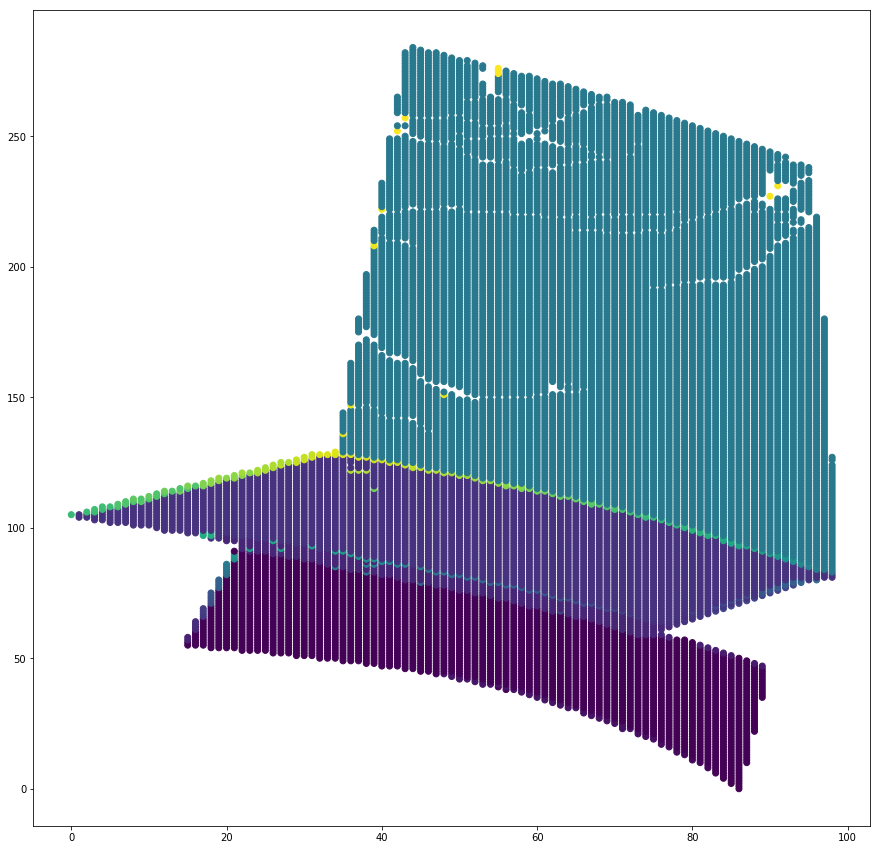

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

labels = np.reshape(pc.labels, (pc.nrows*pc.ncols))
labels[labels==0] = None

grid = [(c, r) for r in range(pc.nrows) for c in range(pc.ncols)]

xs, ys = zip(*grid)
ax.scatter(xs, ys, c=labels)

plt.show()

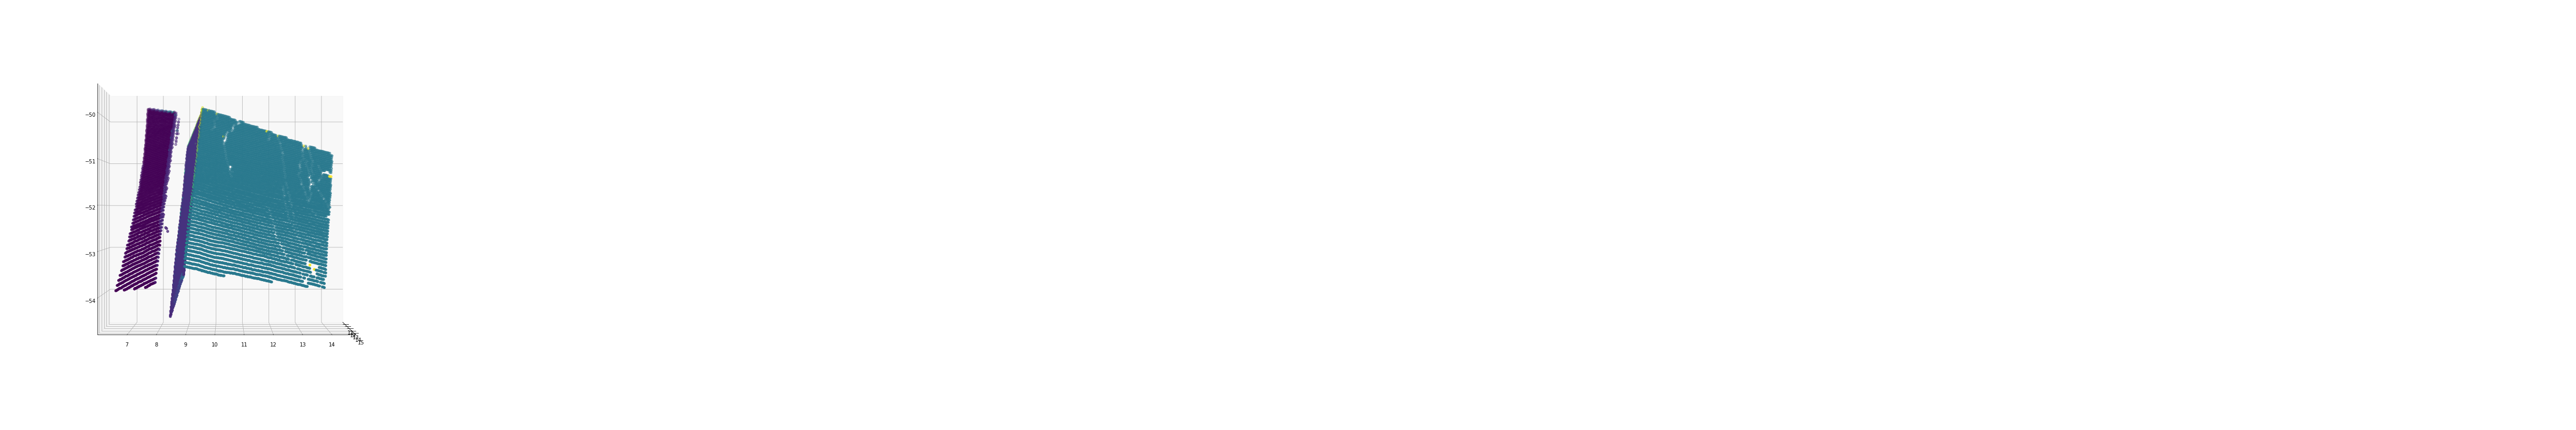

In [282]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)

# normals = np.reshape(pc.normals, (pc.nrows*pc.ncols, 3))[:, 2]
# normals[normals==0] = None
labels = np.reshape(pc.labels, (pc.nrows*pc.ncols))
labels[labels==0] = None

# grid = [(c, r) for r in range(pc.nrows) for c in range(pc.ncols)]
# xs, ys = zip(*grid)
xs, ys, zs = zip(*np.reshape(pc.points, (pc.nrows*pc.ncols, 3)))
ax.scatter(xs, ys, zs, c=labels)
ax.view_init(0, 0)

plt.show()

[0.27355775 0.07261661 0.95911052] 45.069498365538 0.5944064623449847 220


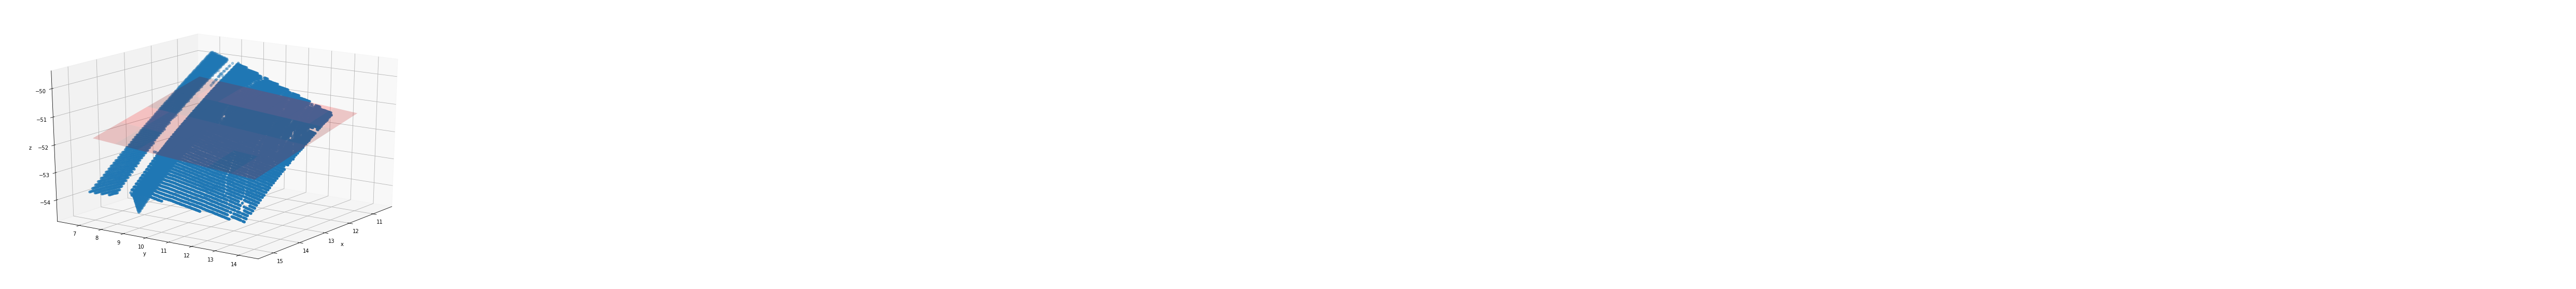

In [227]:
normal, d, fit_error, n = RANSAC_1(pc, 0.60)
print(normal, d, fit_error, n)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

px, py = np.meshgrid(range(11, 16), range(7, 15))
pz = -(normal[0]*px + normal[1]*py + d) / normal[2]

ax.plot_surface(px, py, pz, alpha=0.2, color='red')

bx = fig.gca()

points = np.reshape(pc.points, (pc.nrows*pc.ncols, 3))
points = points[np.any(points, axis=1)]
xs, ys, zs = zip(*points)

bx.scatter(xs, ys, zs)

ax.view_init(20, 35)
bx.view_init(20, 35)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

[ 0.7069737  -0.02218002  0.70689195] 27.39503035635943 0.07485747040500663 19


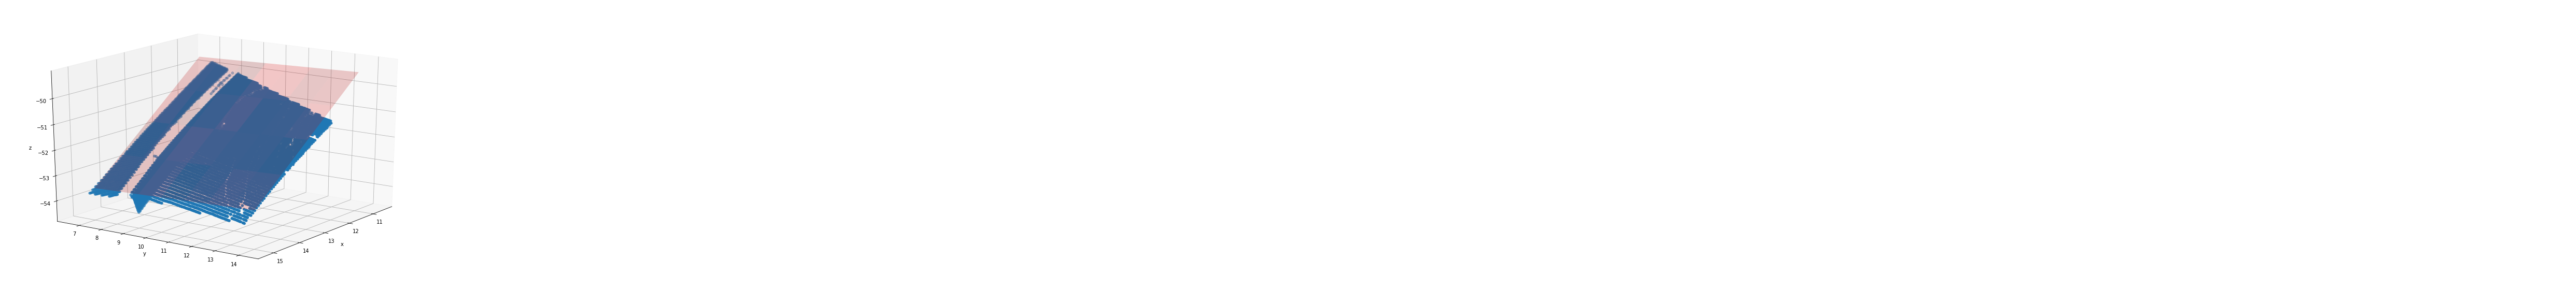

In [226]:
normal, d, fit_error, n = RANSAC_3(pc, 0.075)
print(normal, d, fit_error, n)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

px, py = np.meshgrid(range(11, 16), range(7, 15))
pz = -(normal[0]*px + normal[1]*py + d) / normal[2]

ax.plot_surface(px, py, pz, alpha=0.2, color='red')

bx = fig.gca()

points = np.reshape(pc.points, (pc.nrows*pc.ncols, 3))
points = points[np.any(points, axis=1)]
xs, ys, zs = zip(*points)

bx.scatter(xs, ys, zs)

ax.view_init(20, 35)
bx.view_init(20, 35)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

In [15]:
ptcld_dir = './DATA/big_example.ptx'
pc_large = PointCloud()
pc_large.read_from_file(ptcld_dir)
print("calculating normals")
pc_large.calculate_normals(2)
print("hough_labeling")
pc.hough_based_labeling(4, 4, 4)
print("region_growing")
pc_large.region_grow(0.7, 3.0, 1.0)

calculating normals
hough_labeling
region_growing


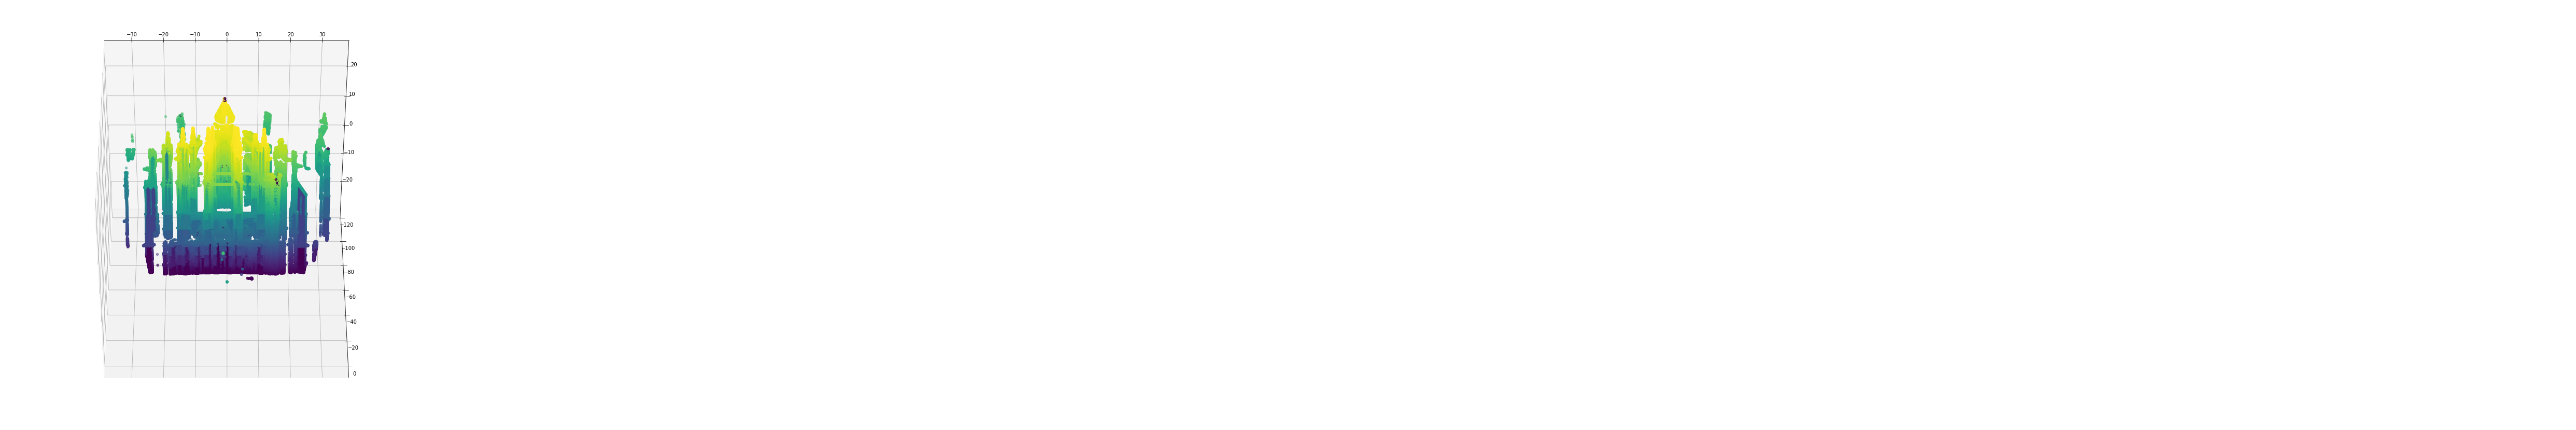

In [16]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt

points = np.reshape(pc_large.points, (pc_large.nrows*pc_large.ncols, 3))
valid = np.any(points, axis=1)
points = points[valid]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

labels = np.reshape(pc_large.labels, (pc_large.nrows*pc_large.ncols))
labels = labels[valid]

xs, ys, zs = zip(*points)
ax.scatter(xs, ys, zs, c=labels)
ax.view_init(135, -90)

plt.show()

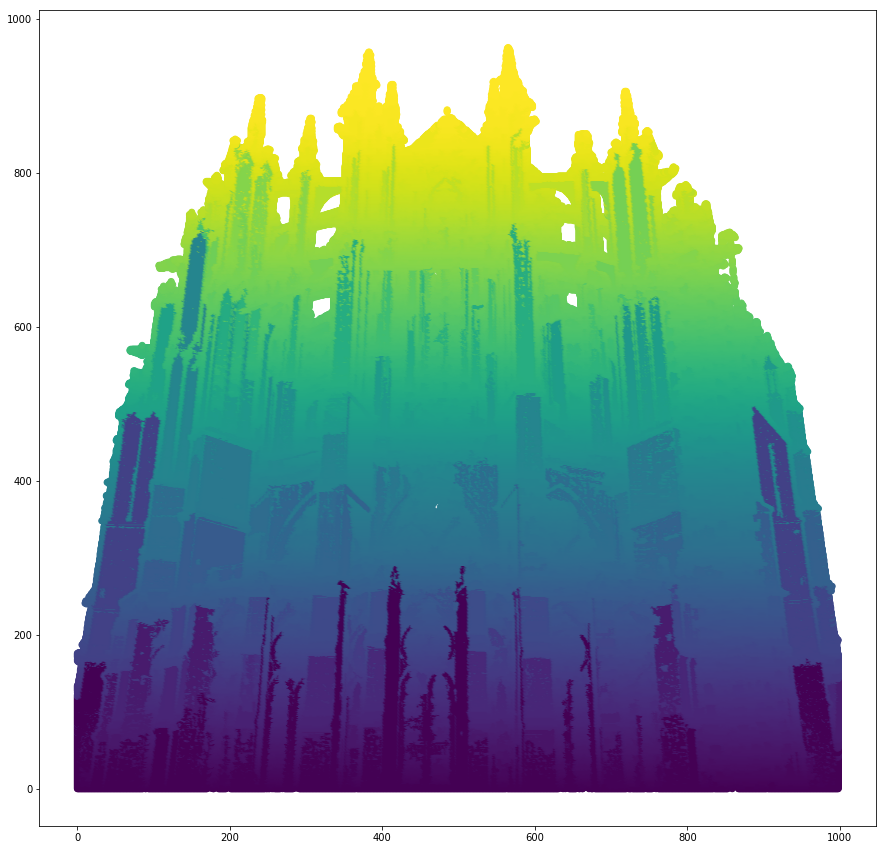

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

labels = np.reshape(pc_large.labels, (pc_large.nrows*pc_large.ncols))
labels[labels==0] = None

grid = [(c, r) for r in range(pc_large.nrows) for c in range(pc_large.ncols)]

xs, ys = zip(*grid)
ax.scatter(xs, ys, c=labels)

plt.show()

Iteration: 0
Iteration: 1
Iteration: 2
[-9.64067104e-05 -6.05913850e-01 -7.95530262e-01] -50.95141417965399 56.79194263535259 3


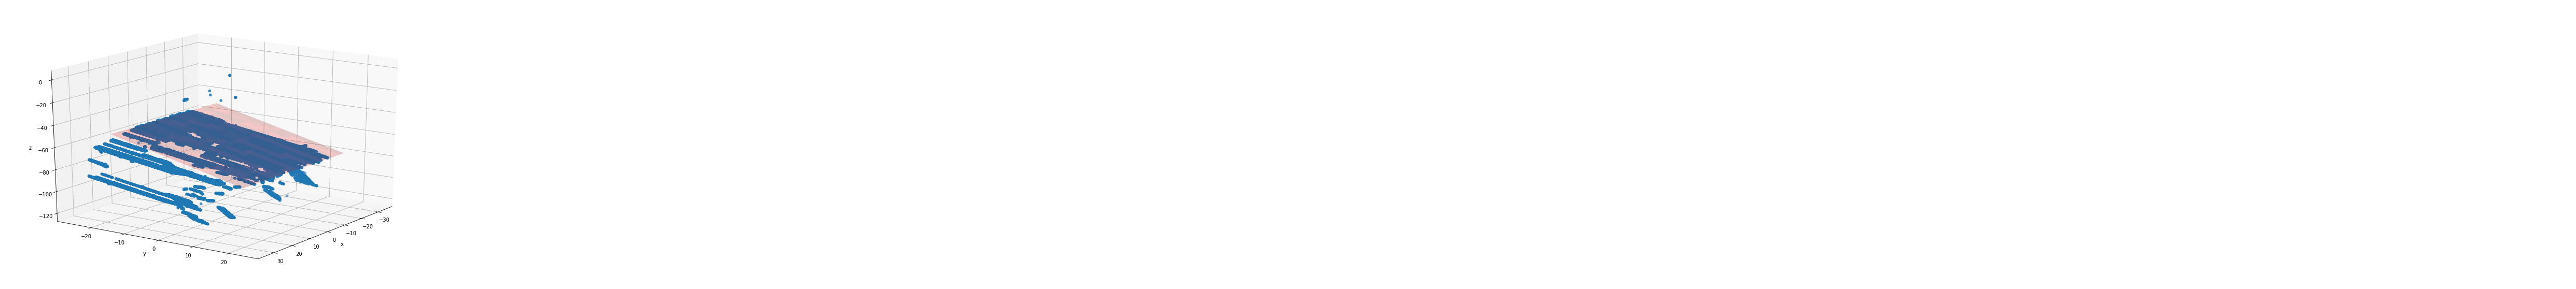

In [6]:
normal, d, fit_error, n = RANSAC_3(pc_large, 100.0, True)
print(normal, d, fit_error, n)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

px, py = np.meshgrid(range(-30, 30, 3), range(-20, 20, 2))
pz = -(normal[0]*px + normal[1]*py + d) / normal[2]

ax.plot_surface(px, py, pz, alpha=0.2, color='red')

bx = fig.gca()

points = np.reshape(pc_large.points, (pc_large.nrows*pc_large.ncols, 3))
points = points[np.any(points, axis=1)]
xs, ys, zs = zip(*points)

bx.scatter(xs, ys, zs)

ax.view_init(20, 35)
bx.view_init(20, 35)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
[0.26861984 0.81568211 0.51235347] 32.72855722881789 59.33022402748604 11


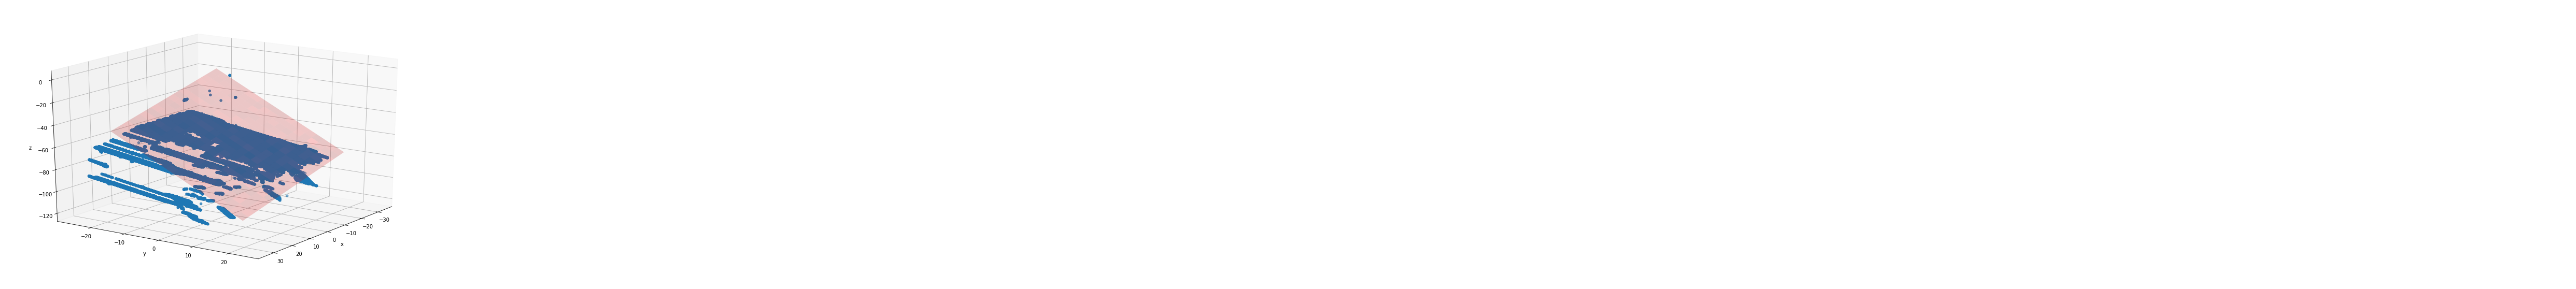

In [10]:
normal, d, fit_error, n = RANSAC_1(pc_large, 70.0, True)
print(normal, d, fit_error, n)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
ax = fig.gca(projection='3d')

px, py = np.meshgrid(range(-30, 30, 3), range(-20, 20, 2))
pz = -(normal[0]*px + normal[1]*py + d) / normal[2]

ax.plot_surface(px, py, pz, alpha=0.2, color='red')

bx = fig.gca()

points = np.reshape(pc_large.points, (pc_large.nrows*pc_large.ncols, 3))
points = points[np.any(points, axis=1)]
xs, ys, zs = zip(*points)

bx.scatter(xs, ys, zs)

ax.view_init(20, 35)
bx.view_init(20, 35)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()